In [134]:
import os
from os import path
import random
import cv2
from tqdm import tqdm
import pickle

import numpy as np
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot
from matplotlib.image import imread
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.autograd import Variable


# https://hackernoon.com/how-to-autoencode-your-pok%C3%A9mon-6b0f5c7b7d97
# https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html
# https://www.youtube.com/watch?v=IKOHHItzukk&list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG&index=18
# https://discuss.pytorch.org/t/layer-reshape-issue/18938/4
# https://towardsdatascience.com/find-similar-images-using-autoencoders-315f374029ea

In [67]:
FOLDER = '/Pictures/'
IMG_SIZE = 50
CURRENT_DIR = path.abspath(path.curdir)
BATCH_SIZE = 16
NUM_EPOCHS = 100
LR = 0.001


img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
files = os.listdir(CURRENT_DIR + FOLDER)
images = []
names = []

for file in tqdm(files):
    
    name = file.split('.')[0]
    names.append(name)

    image = cv2.imread(os.path.join(CURRENT_DIR + FOLDER,file))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
    images.append(image)

# train_set = [(images[i], names[i]) for i in range(0, len(images))]
train_set = pd.DataFrame({'image':images,'name':names}).sample(frac=1).reset_index(drop=True)

100%|██████████| 890/890 [00:02<00:00, 406.53it/s]


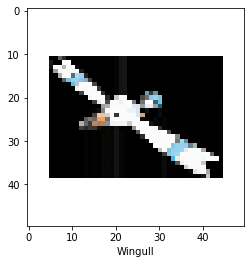

In [5]:
sample = train_set.sample(n=1)
pyplot.imshow(sample['image'].values[0])
label = sample['name'].values[0]
pyplot.xlabel(label)

pyplot.show()

In [6]:
class ImageDataset(Dataset):

    def __init__(self,data,transform=img_transform):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self,index):
        if torch.is_tensor(index):
            index = index.tolist()

        item = self.data.iloc[index]
        name = item[1]
        image = item[0]/255
        
        if self.transform:
            sample = self.transform(image)
        
        return np.moveaxis(image,-1,0), name
    
dataset = ImageDataset(train_set)

In [57]:
dataloader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
    )

In [8]:
sample = next(iter(dataloader))
images, labels = sample
images.shape    

torch.Size([16, 3, 50, 50])

In [131]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.Conv1 = nn.Conv2d(3,16,3)
        self.Conv2 = nn.Conv2d(16,32,3)
        self.Conv3 = nn.Conv2d(32,64,7)
                
        self.pool = nn.MaxPool2d(2,2,return_indices=True)
        
        self.FC1 = nn.Linear(64*5*5, 64*5*5)
        
        self.ConvTrans3 = nn.ConvTranspose2d(64,32,7)
        self.ConvTrans2 = nn.ConvTranspose2d(32,16,3)
        self.ConvTrans1 = nn.ConvTranspose2d(16,3,3)
        
        self.unpool = nn.MaxUnpool2d(2,2)
        self.sig = nn.Sigmoid()
        
        

    def forward(self, x):
        
        x = self.Conv1(x)
        x = F.relu(x)
        x, indices1 = self.pool(x)
        x = self.Conv2(x)
        x = F.relu(x)
        x, indices2 = self.pool(x)
        x = self.Conv3(x)
        x = x.view(-1,16*5*5)
#         x = F.relu(self.FC1(x))
        
#         x = self.ConvTrans3(x)
#         x = self.unpool(x,indices2)
#         x = F.relu(x)
#         x = self.ConvTrans2(x)
#         x = self.unpool(x,indices1)
#         x = F.relu(x)
#         x = self.ConvTrans1(x)
#         x = self.sig(x)
        
        return x

In [132]:
model = Autoencoder().float()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR,
                             weight_decay=1e-5)

In [133]:
sample = next(iter(dataloader))
images, labels = sample
images = images.float()
print(images.shape)
with torch.no_grad():
    x = model(images)
print(x.shape)

torch.Size([16, 3, 50, 50])
torch.Size([64, 400])


In [63]:
def train(model, num_epochs, criterion, optimizer, dataloader):
    torch.manual_seed(42)

    outputs = []
    for epoch in range(num_epochs):
        for data in dataloader:
            img, _ = data
            recon = model(img.float())
            loss = criterion(recon.double(), img.double())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f'Epoch:{epoch+1}, Loss:{float(loss)}')
        outputs.append((epoch, img, recon),)
    return outputs

In [71]:
test = train(model, NUM_EPOCHS, criterion, optimizer, dataloader)

Epoch:1, Loss:0.006681835471197926
Epoch:2, Loss:0.0061746657798302075
Epoch:3, Loss:0.00781464357228753
Epoch:4, Loss:0.006091181012759935
Epoch:5, Loss:0.006697396753246742
Epoch:6, Loss:0.005996747221071674
Epoch:7, Loss:0.006332966823874444
Epoch:8, Loss:0.005362640494000491
Epoch:9, Loss:0.005467593294340776
Epoch:10, Loss:0.006173827985227011
Epoch:11, Loss:0.006221980364466438
Epoch:12, Loss:0.006537476019422196
Epoch:13, Loss:0.014307962962702583
Epoch:14, Loss:0.005734850905775828
Epoch:15, Loss:0.007613815708915169
Epoch:16, Loss:0.00622897397184643
Epoch:17, Loss:0.006283371102582524
Epoch:18, Loss:0.0064804422878368875
Epoch:19, Loss:0.007190595865344918
Epoch:20, Loss:0.005671415228349103
Epoch:21, Loss:0.006755079603940096
Epoch:22, Loss:0.006106149729482247
Epoch:23, Loss:0.005278301446909194
Epoch:24, Loss:0.005743552315537226
Epoch:25, Loss:0.0061160632411787035
Epoch:26, Loss:0.006411613141813031
Epoch:27, Loss:0.006035026140381354
Epoch:28, Loss:0.005317653895753213


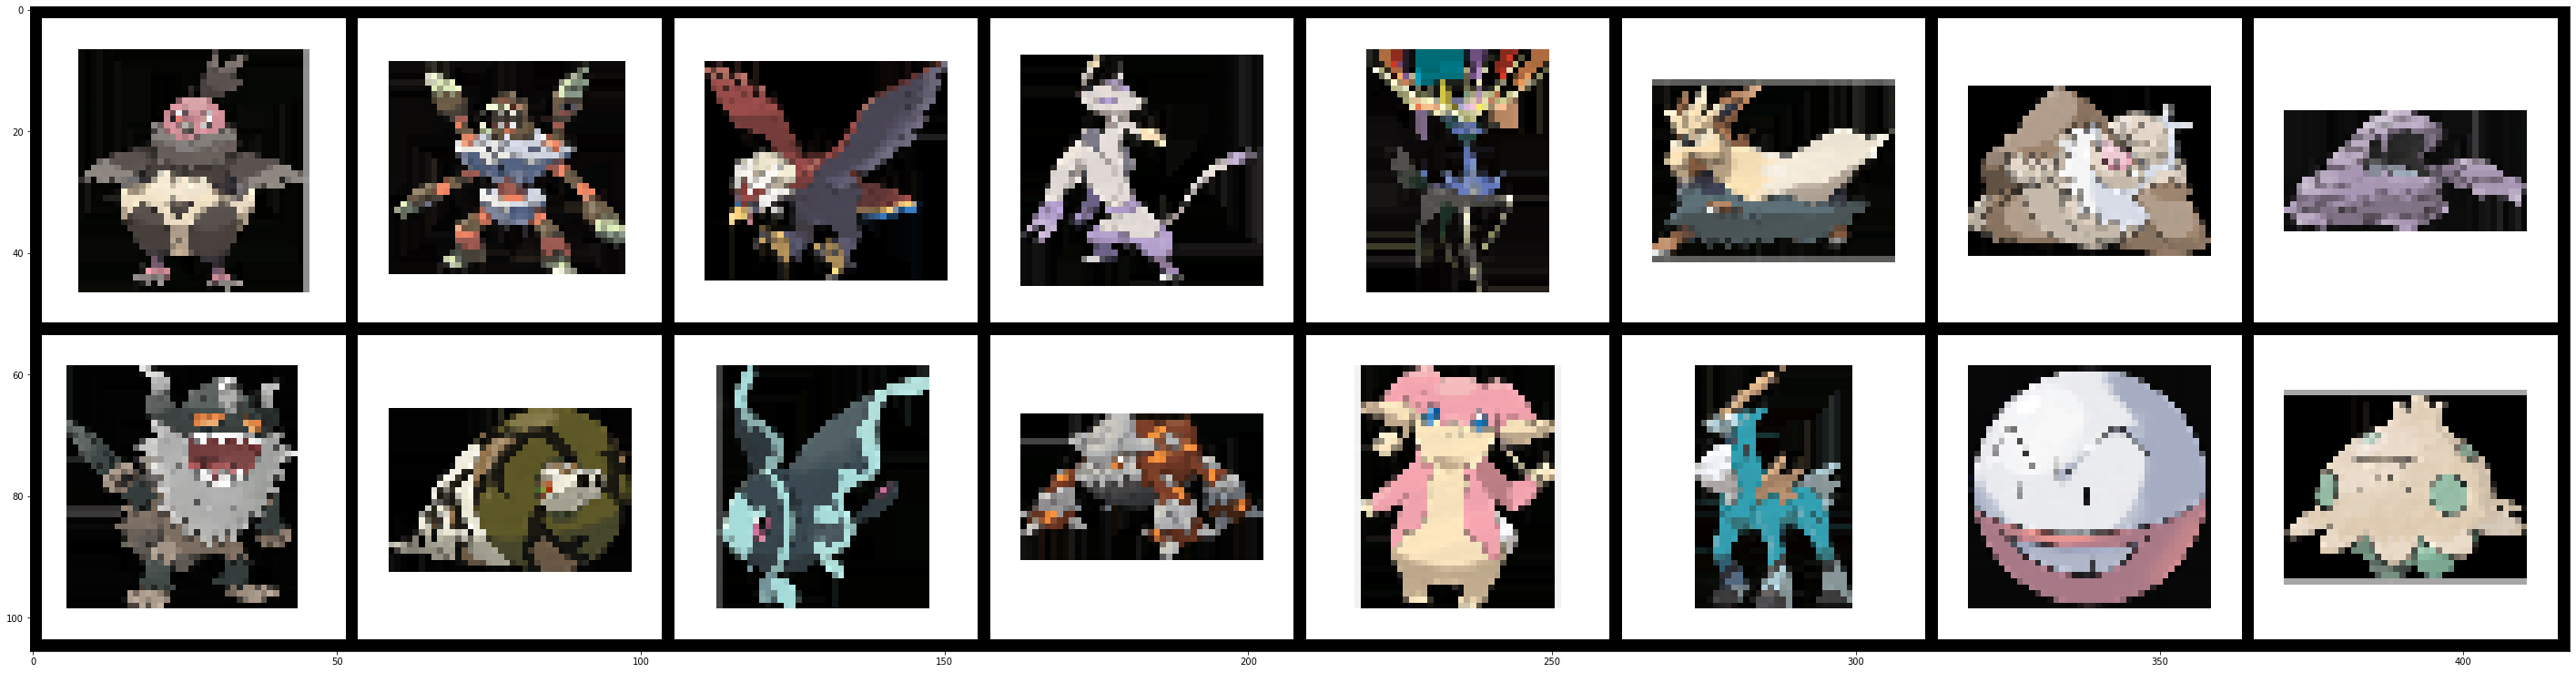

In [72]:
sample = next(iter(dataloader))
images, labels = sample
grid = torchvision.utils.make_grid(images,nrow=8)
plt.figure(figsize=(50,50))
plt.imshow(grid.numpy().transpose(1,2,0))

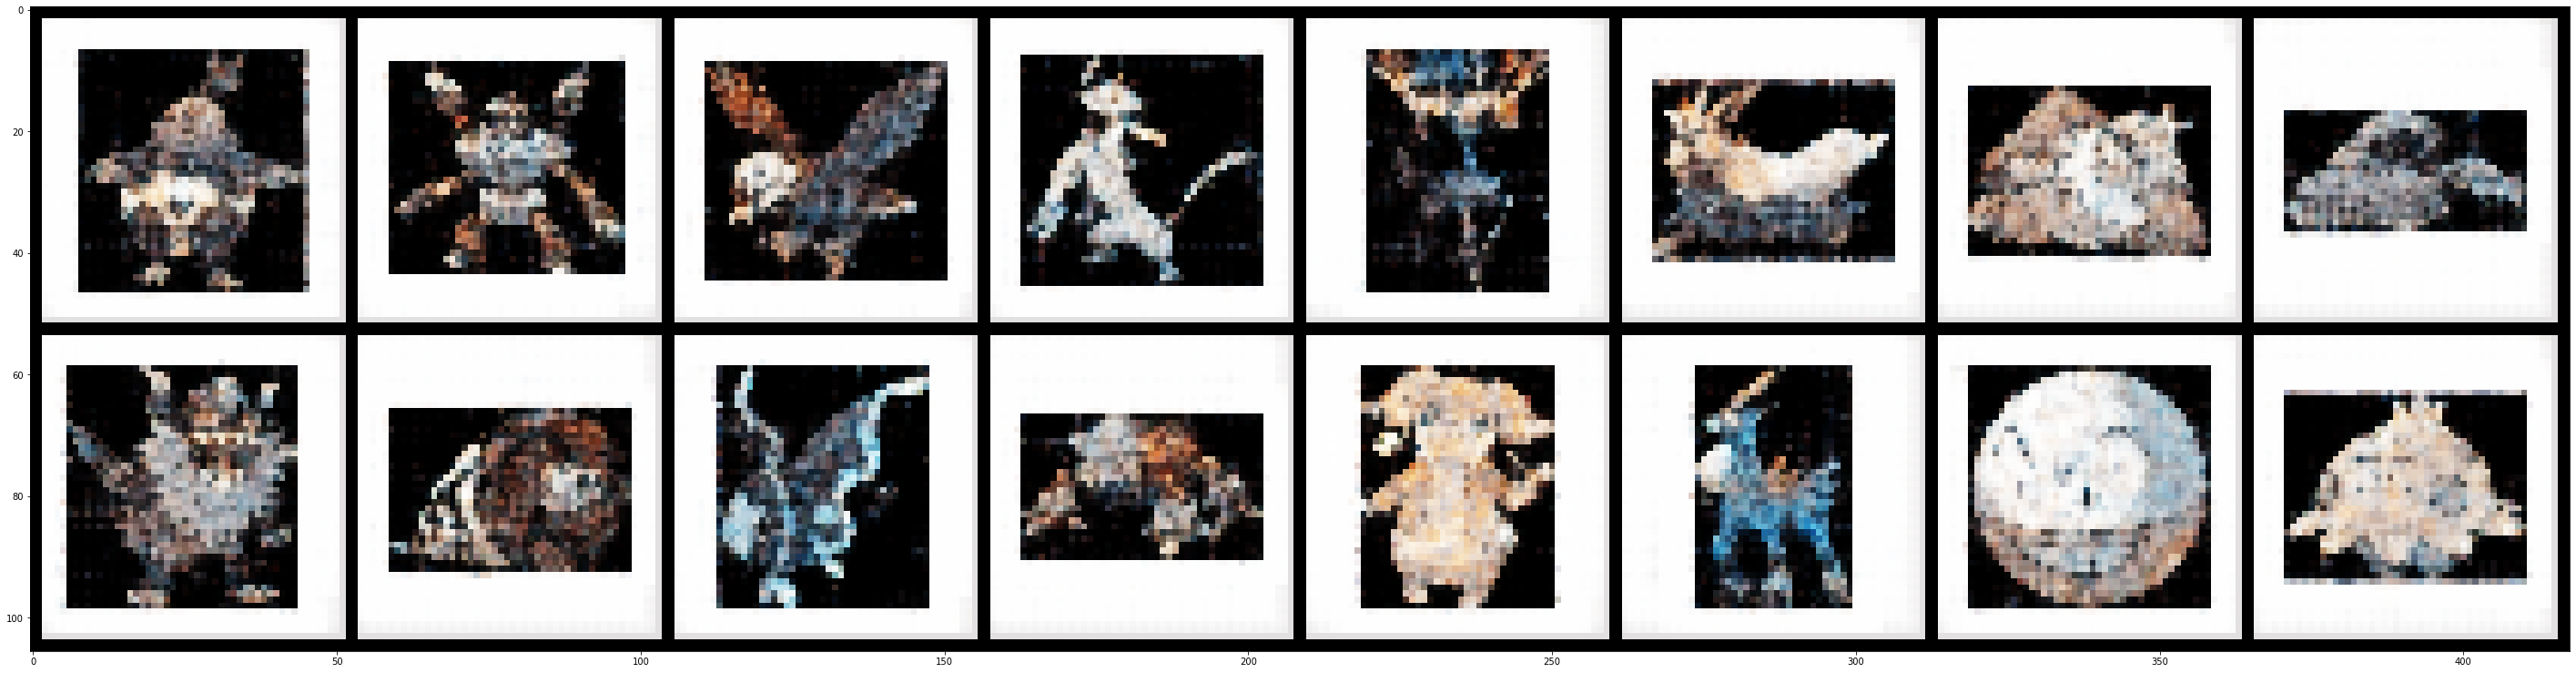

In [73]:
with torch.no_grad():
    test_images = model(images.float())
test_grid = torchvision.utils.make_grid(test_images,nrow=8)
plt.figure(figsize=(50,50))
plt.imshow(test_grid.numpy().transpose(1,2,0))

In [18]:
test_images

tensor([[[205.3847, 235.0434, 235.8757,  ..., 186.8013, 193.6410, 143.9527],
         [235.5971, 256.4306, 261.7524,  ..., 240.7412, 221.7701, 143.9527],
         [239.0037, 257.2755, 263.2187,  ..., 266.3659, 236.9146, 143.9527],
         ...,
         [185.1014, 240.7412, 262.9188,  ..., 240.7412, 221.7701, 143.9527],
         [190.8142, 223.5174, 234.0877,  ..., 223.5174, 187.2263, 143.9527],
         [143.9527, 143.9527, 143.9527,  ..., 143.9527, 143.9527, 143.9527]],

        [[216.1196, 239.5678, 236.3020,  ..., 191.7077, 197.6874, 164.1110],
         [242.3094, 254.4490, 261.7215,  ..., 240.4437, 222.4528, 164.1110],
         [241.7488, 258.0924, 259.4015,  ..., 258.3617, 234.4442, 164.1110],
         ...,
         [196.6157, 240.4437, 254.9575,  ..., 240.4437, 222.4528, 164.1110],
         [198.4713, 230.7651, 235.2280,  ..., 230.7651, 200.8678, 164.1110],
         [164.1110, 164.1110, 164.1110,  ..., 164.1110, 164.1110, 164.1110]],

        [[214.6589, 237.3271, 233.5838,  ...